# Quickstart

Let us try to process an actual burst from an FRB using `scarab`. We are using one of the bursts detected from FRB 20240114A using the uGMRT, which is from a collection of 167 bursts reported in [Panda et al. 2024](https://arxiv.org/abs/2405.09749). The burst is stored in a SIGPROC filterbank file. The data has 128 channels, and a sampling time of 10.24 $\mu$s. The burst was detected in Band 4 (550 to 750 MHz) of the uGMRT. In the following section, we will load the burst, transform the data so that it can be further processed, carry out DM optimisation of the burst, and then fit models to its profile and spectrum. Before we do any of that, let us import the necessary functions and classes from `scarab`:

In [1]:
from scarab.base import Burst
from scarab.fit import Fitter
from scarab.dm import DMOptimizer
from scarab.transform import Transformer

In [2]:
from pathlib import Path

basedir = Path("../frbfollow/240114A").resolve()

burstpaths = list(
    (
        basedir
        / "ddtc333"
        / "detections"
        / "chopped_cd"
    ).glob("*SNR37.29*.fil")
)

burstpath = burstpaths[0]

[PosixPath('/mnt/disk2/data/Ujjwal/frbfollow/240114A/ddtc333/detections/chopped_cd/frb240114A_SCAN5_T4645.969265_DM_530.3_SNR37.29.fil')]

Now, we load the data (**NOTE**: the `burstpath` variable stores the path to the SIGPROC filterbank file):

In [3]:
burst = Burst.new(burstpath)

Now, we transform the data. To do this, `scarab` provides a `Transformer` class, which can carry out multiple processes on the data in a chain, and output the result. More details are covered in the **Transforming your data** section of the documentation. We first create a `Transformer` instance for our burst, and then carry out the following operations:

1. Bandpass normalisation,
2. Dedispersion (at the detected DM),
3. Downsampling along both frequency and time,
4. Time clipping,
5. Emission masking.

In [4]:
T = Transformer.new(burst, inplace=True)
T = (
    T
    .normalise()
    .dedisperse(dm=530.3)
    .scrunch(tf=16, ff=1)
    .clip(within=50e-3)
    .mask(boxwidth=10, snrthres=10.0)
)

After all the above operations are done, we can now see the burst by plotting it:

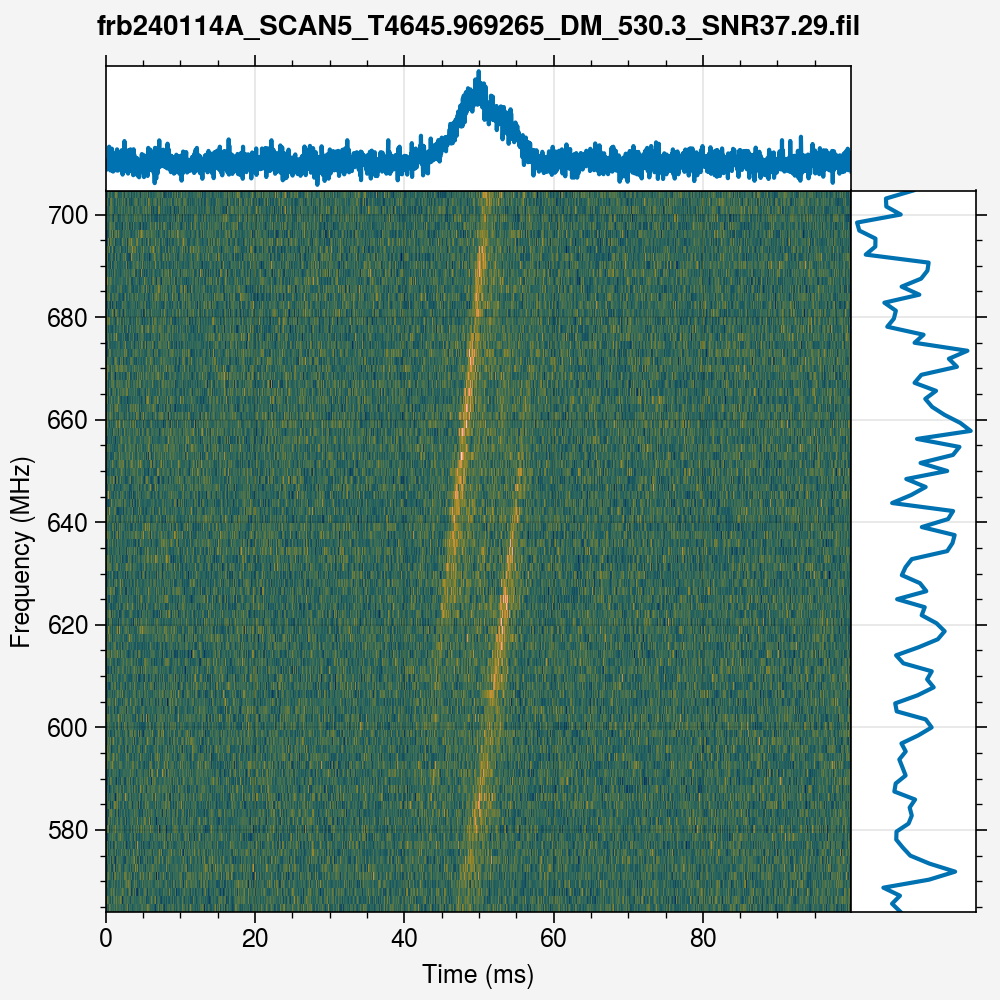

In [5]:
burst.plot()

From the above plot, it is apparent that the detection DM is wrong. To correct for it, we will now carry out DM optimisation. Further details are given in the **DM Optimisation** section of the documentation, but the gist of it is to create a `DMOptimizer` instance for our burst, and then call the `viastructure` method to carry out DM optimisation using the methodology implemented in [**`SHRINE`**](https://github.com/marcinglowacki/SHRINE):

In [6]:
dmopt = DMOptimizer.new(burst)
dmopt.viastructure()

We then dedisperse the burst again, using the structure-optimised DM obtained above:

In [7]:
T = Transformer.new(burst)
burst = T.dedisperse(dm=burst.dm + dmopt.ddmopt).transformed

And plot it to see if our efforts have borne fruit:

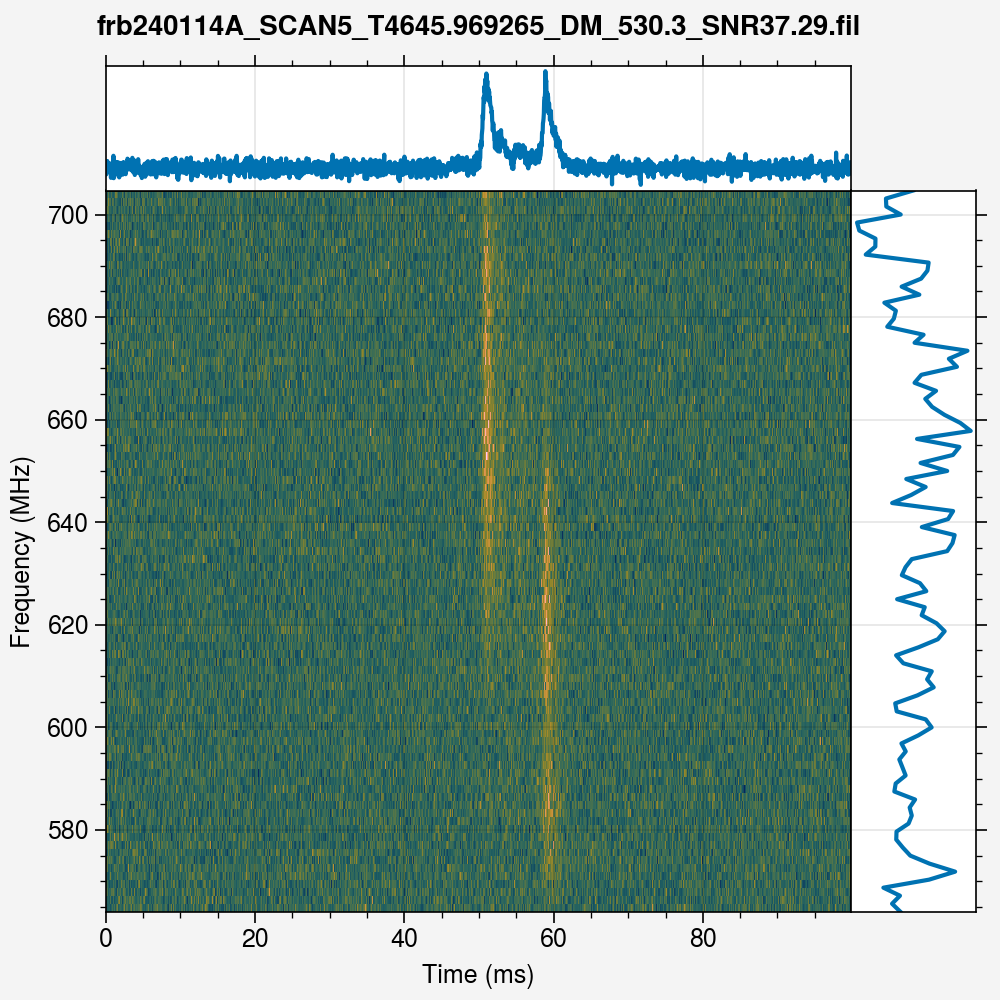

In [8]:
burst.plot()

And lo! The burst is now dedispersed at the correct DM, and its multicomponent nature is clearly visible. We can now go ahead and fit the profile and spectrum of the burst, using the models available in `scarab`. The profile models are currently the same as those found in the [**`scatfit`**](https://github.com/fjankowsk/scatfit) package, whereas the spectrum models are taken from the [**`fitburst`**](https://github.com/CHIMEFRB/fitburst) package. First, let us assume that there are no multiple components, and see how does this fit go. To fit the burst, we use the `fit` method from the `Fitter` class. Note that this is a *classmethod*, and running it returns an instance of the `Fitter` class, which has all the post-fit parameters. We need to specify which burst to fit, which models to use, and whether or not the burst contains multiple components:

In [9]:
fitter = Fitter.fit(
    burst,
    multiple=False,
    withmodels=(
        "scattering_isotropic_analytic",
        "running_power_law",
    )
)

Output()

We can now plot it to see the results for ourselves:

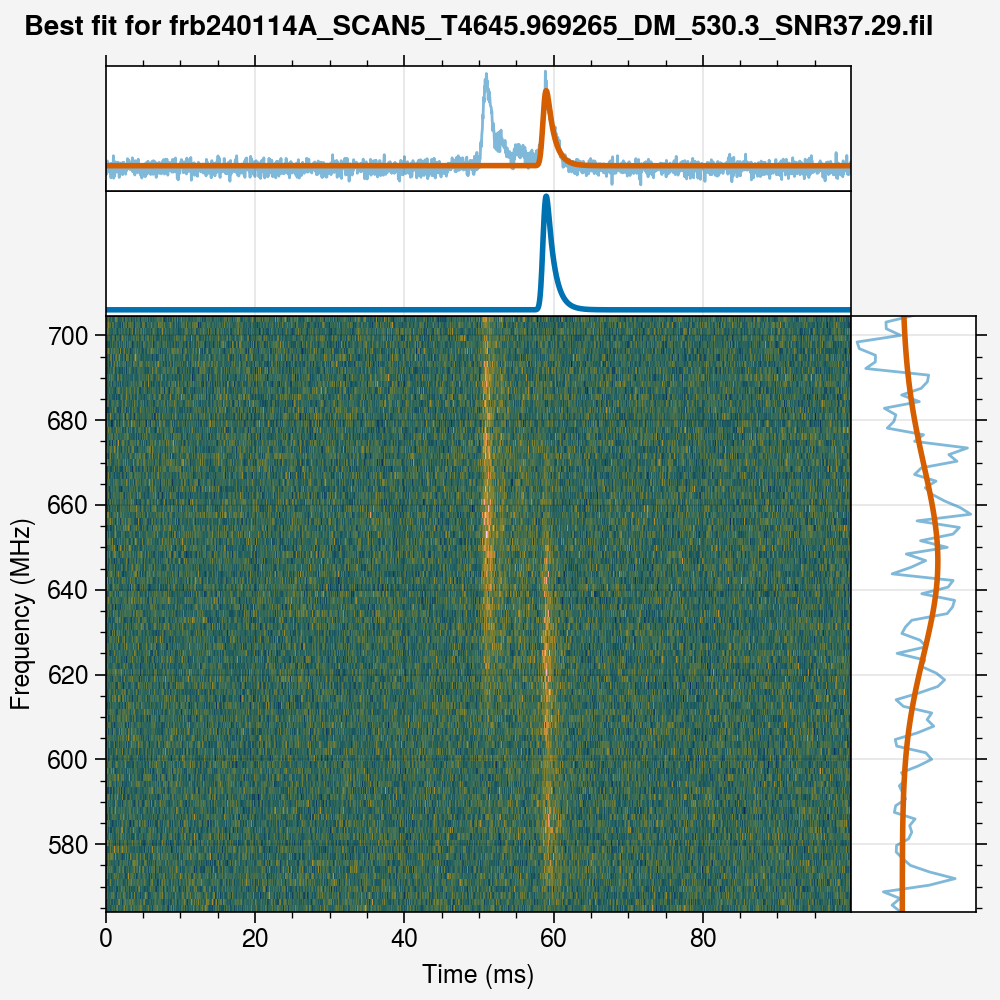

In [10]:
fitter.plotfit()

While oen component is fit well enough, the other (brighter) component has been completely ignored. To fit multiple components, we just pass the `multiple` flag to the `Fitter` class when using it to fit our burst:

In [11]:
fitter = Fitter.fit(
    burst,
    njobs=24,
    multiple=True,
    withmodels=(
        "scattering_isotropic_analytic",
        "running_power_law",
    )
)

Output()

This detects the peaks from the burst automatically. Then, it selects the brightest component, and just fits the model for that component. Then, it adds the next brightest component to the model, and fits again. It keeps doing so until all components detected by the peak-finding algorithm have been added to the model. Then, it compares all the models using the Bayesian Information Criterion (BIC) to see which model fits the data the best, and that is assumed to be the correct number of components for the burst. We can now plot the burst to see whether our automatic component detection has worked or not:

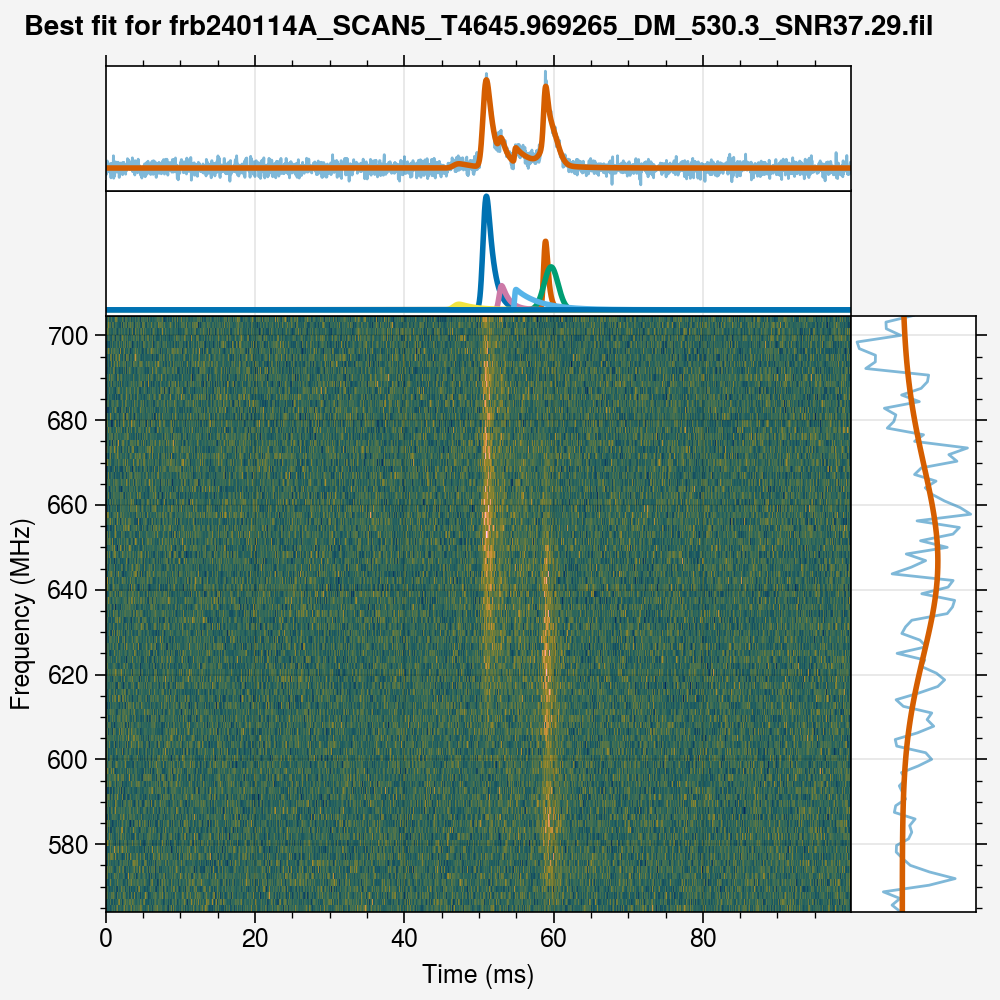

In [12]:
fitter.plotfit()